# Week 4: Predicting the next word

Welcome to this assignment! During this week you saw how to create a model that will predict the next word in a text sequence, now you will implement such model and train it using a corpus of [Shakespeare Sonnets](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), while also creating some helper functions to pre-process the data.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.


- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.
- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!
- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [2]:
import unittests

## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

- `FILE_PATH`: The file path where the sonnets file is located. 

- `NUM_BATCHES`: Number of batches. Defaults to 16.
- `LSTM_UNITS`: Number of LSTM units in the LSTM layer.
- `EMBEDDING_DIM`: Number of dimensions in the embedding layer.

In [3]:
FILE_PATH = './data/sonnets.txt'
NUM_BATCHES = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**

### Reading the dataset

For this assignment you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [4]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Exercise 1: fit_vectorizer

In this exercise, you will use the [tf.keras.layers.TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to tokenize and transform the text into numeric values. 

Note that in this case you will not pad the sentences right now as you've done before, because you need to build the n-grams before padding, so pay attention with the appropriate arguments passed to the TextVectorization layer!

**Note**:
- You should remove the punctuation and use only lowercase words, so you must pass the correct argument to TextVectorization layer.

- In this case you will not pad the sentences with the TextVectorization layer as you've done before, because you need to build the n-grams before padding. Remember that by default, the TextVectorization layer will return a Tensor and therefore every element in it must have the same size, so if you pass two sentences of different length to be parsed, they will be padded. If you do not want to do that, you need to either pass the parameter ragged=True, or pass only a single sentence at the time. Later on in the assignment you will build the n-grams and depending on how you will iterate over the sentences, this may be important. If you choose to first pass the entire corpus to the TextVectorization and then perform the iteration, then you should pass ragged=True, otherwise, if you use the TextVectorization on each sentence separately, then you should not worry about it.


In [7]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus
    
    Args:
        corpus (list): List with the sentences.
    
    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary, adapted to the corpus sentences.
    """    

    tf.keras.utils.set_random_seed(65) # Do not change this line or you may have different expected outputs throughout the assignment

    ### START CODE HERE ###

    # Define the object
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',  # Lowercase and remove punctuation
        output_mode='int',  # We want to output integer indices for each word
        output_sequence_length=None,  # Do not pad the sequences yet
        ragged=True  # Allow variable-length input sequences (no padding)
    )
    
    # Adapt it to the corpus
    vectorizer.adapt(corpus)


    ### END CODE HERE ###
    
    return vectorizer

In [8]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Total number of words in corpus (including the out of vocabulary): 3189


**Expected output:**

```
Total number of words in corpus (including the out of vocabulary): 3189
```

One thing to note is that you can either pass a string or a list of strings to vectorizer. If you pass the former, it will return a *tensor* whereas if you pass the latter, it will return a *ragged tensor* if you've correctly configured the TextVectorization layer to do so.

In [9]:
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679])>
Passing a list of strings: <tf.RaggedTensor [[29, 14, 18, 1, 1679]]>


**Expected output:**

```
Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679])>
Passing a list of strings: <tf.RaggedTensor [[29, 14, 18, 1, 1679]]>
```

In [10]:
# Test your code!
unittests.test_fit_vectorizer(fit_vectorizer)

 All tests passed!


## Generating n-grams

As you saw in the lecture, the idea now is to generate the n-grams for each sentence in the corpus. So, for instance, if a vectorized sentence is given by `[45, 75, 195, 879]`, you must generate the following vectors:

```Python
[45, 75]
[45, 75, 195]
[45, 75, 195, 879]
```
## Exercise 2: n_grams_seqs

Now complete the `n_gram_seqs` function below. This function receives the fitted vectorizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus.

**NOTE:**

- If you pass `vectorizer(sentence)` the result is not padded, whereas if you pass `vectorizer(list_of_sentences)`, the result won't be padded **only if you passed the argument `ragged = True`** in the TextVectorization setup.
- This exercise directly depends on the previous one, because you need to pass the defined vectorizer as a parameter, so any error thrown in the previous exercise may propagate here.

In [76]:
# GRADED FUNCTION: n_gram_seqs

def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus
    
    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE ###
    for line in corpus:
        token_list = vectorizer([line])[0]
        
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    
    ### END CODE HERE ###
    
    return input_sequences

In [77]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], vectorizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 35, 489])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  35,  489, 1259])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  35,  489, 1259,  164])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230,  582])>]

**Expected Output:**

```
n_gram sequences for first example look like this:

[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 35, 489])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  35,  489, 1259])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  35,  489, 1259,  164])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230,  582])>]
```

In [78]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], vectorizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  9, 935])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  9, 935, 143])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  9, 935, 143, 369])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  9, 935, 143, 369, 101])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171, 207])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([17, 23])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17, 23,  3])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  17,   23,    3, 1006])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51])>,
 <tf.Tensor: shape=(8,), dtype=int64, numpy=array([  17,   23,   

**Expected Output:**

```
n_gram sequences for next 3 examples look like this:

[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  9, 935])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  9, 935, 143])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  9, 935, 143, 369])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  9, 935, 143, 369, 101])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171, 207])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([17, 23])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17, 23,  3])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  17,   23,    3, 1006])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51])>,
 <tf.Tensor: shape=(8,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51,  803])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 27, 315])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 27, 315, 745])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 27, 315, 745, 101])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 27, 315, 745, 101, 209])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 27, 315, 745, 101, 209,  27])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 27, 315, 745, 101, 209,  27, 286])>]
```

In [79]:
# Test your code!
unittests.test_n_gram_seqs(n_gram_seqs)

 All tests passed!


Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [80]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15355
maximum length of sequences is: 11


**Expected Output:**

```
n_grams of input_sequences have length: 15355
maximum length of sequences is: 11
```

## Exercise 3: pad_seqs

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences. You may have a look at the documentation of [`tf.keras.utils.pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences). 

**NOTE**: 

- Remember to pass the correct padding method as discussed in the lecture.

In [94]:
# GRADED FUNCTION: pad_seqs

def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """
    
    ### START CODE HERE ###

    padded_sequences = tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

    ### END CODE HERE ###
    
    return padded_sequences

In [95]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]], dtype=int32)

**Expected Output:**

```
array([[   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]], dtype=int32)
```

In [96]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,    0,   27,  315,  745],
       [   0,    0,    0,    0,   27,  315,  745,  101],
       [   0,    0,    0,   27,  315,  745,  101,  209],
       [   0,    0,   27,  315,

**Expected Output:**

```
array([[   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,    0,   27,  315,  745],
       [   0,    0,    0,    0,   27,  315,  745,  101],
       [   0,    0,    0,   27,  315,  745,  101,  209],
       [   0,    0,   27,  315,  745,  101,  209,   27],
       [   0,   27,  315,  745,  101,  209,   27,  286]], dtype=int32)
```

In [97]:
# Test your code!
unittests.test_pad_seqs(pad_seqs)

 All tests passed!


In [98]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15355, 11)


**Expected Output:**

```
padded corpus has shape: (15355, 11)

```

## Exercise 4: features_and_labels_dataset

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the *padded n_gram sequences* with the **last element** removed from them and the labels will be the removed words.

Complete the `features_and_labels_dataset` function below. This function expects the `padded n_gram sequences` as input and should return a **batched** [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) containing elements in the form (sentence, label). 


**NOTE**:
- Notice that the function also receives the total of words in the corpus, this parameter will be **very important when one hot encoding the labels** since every word in the corpus will be a label at least once. The function you should use is [`tf.keras.utils.to_categorical`]((https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)).
- To generate a dataset you may use the function [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) after obtaining the sentences and their respective labels.
- To batch a dataset, you may call the method [.batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch). A good number is `16`, but feel free to choose any number you want to, but keep it not greater than 64, otherwise the model may take too many epochs to achieve a good accuracy. Remember this is defined as a global variable.

In [99]:
# GRADED FUNCTION: features_and_labels

def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """
    ### START CODE HERE ###

    # Define the features an labels as discussed in the lectures
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]

    # One hot encode the labels
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    # Build the dataset with the features and one hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels)) 

    # Batch de dataset with number of batches given by the global variable
    batched_dataset = dataset.batch(16)

    ### END CODE HERE ##

    return batched_dataset

In [100]:
# Test your function with the padded n_grams_seq of the first example
dataset_example = features_and_labels_dataset(first_padded_seq, total_words)

print("Example:\n")
for features, label in dataset_example.take(1):
    print(f"N grams:\n\n {features}\n")
    print(f"Label shape:\n\n {label.shape}")

Example:

N grams:

 [[   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (5, 3189)


**Expected Output:**

```
Example:

N grams:

 [[   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (5, 3189)
```

In [101]:
# Test your code!
unittests.test_features_and_labels_dataset(features_and_labels_dataset)

 All tests passed!


Now let's generate the whole dataset that will be used for training. In this case, let's use the [.prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) method to speed up the training. Since the dataset is not that big, you should not have problems with memory by doing this. 

In [102]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)

print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float64, name=None)


**Expected Output:**

```
Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float32, name=None)
```

## Exercise 5: create_model

Now you should define a model architecture capable of achieving an accuracy of at least 80%.

Some hints to help you in this task:

- The first layer in your model must be an [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer with the appropriate parameters, remember that your input are vectors with a fixed length size. Be careful with the size value you should pass as you've removed the last element of every input to be the label.

- An appropriate `output_dim` for the first layer (Embedding) is 100, this is already provided for you.
- A Bidirectional LSTM is helpful for this particular problem.
- The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.
- This problem can be solved with only two layers (excluding the Embedding and Input) so try out small architectures first.
- 30 epochs should be enough to get an accuracy higher than 80%, if this is not the case try changing the architecture of your model.

In [120]:
# GRADED FUNCTION: create_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
       (tf.keras Model): the text generator model
    """
    model = tf.keras.Sequential()

    ### START CODE HERE ###
    model.add(tf.keras.layers.Input(shape=(None,)))
    model.add(tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.
- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [121]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 1,579,989 total parameters and the reference is 2,000,000. You are good to go!

Your model has 1,579,989 trainable parameters and the reference is 2,000,000. You are good to go!


In [122]:
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (16, 3189)


**Expected output:**

```
predictions have shape: (NUM_BATCHES, 3189)
```

Where `NUM_BATCHES` is the number of batches you have set to your dataset.

In [118]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


In [119]:
# Train the model
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0257 - loss: 7.0546
Epoch 2/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0276 - loss: 6.1541
Epoch 3/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0384 - loss: 5.7835
Epoch 4/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0483 - loss: 5.4383
Epoch 5/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0601 - loss: 5.2175
Epoch 6/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0663 - loss: 5.0472
Epoch 7/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0830 - loss: 4.7660
Epoch 8/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1096 - loss: 4.4893
Epoch 9/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1449 - loss: 4.1997
Epoch 10/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2021 - loss: 3.8673
Epoch 11/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2600 - loss: 3.5539
Epoch 12/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/ste

**To pass this assignment, your model should achieve a training accuracy of at least 80%**. If your model didn't achieve this threshold, try training again with a different model architecture. Consider increasing the number of units in your `LSTM` layer.

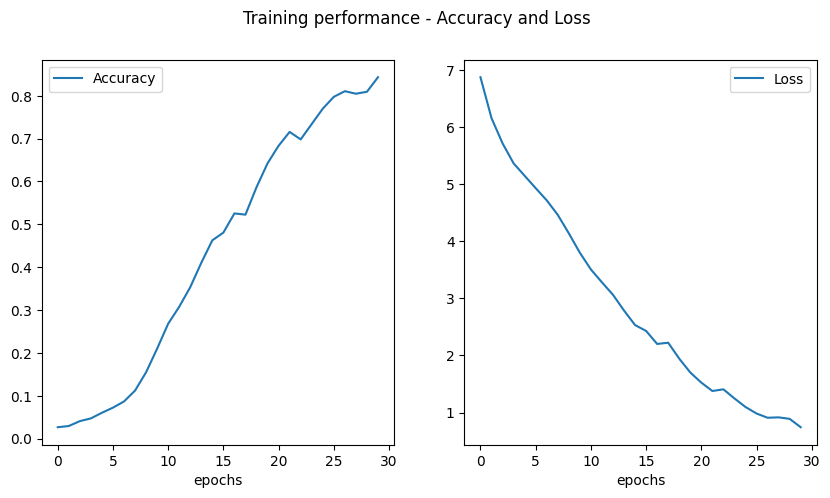

In [123]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance - Accuracy and Loss')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

If the accuracy meets the requirement of being greater than 80%, then save the `history.pkl` file which contains the information of the training history of your model and will be used to compute your grade. You can do this by running the following code:

In [124]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## See your model in action

After all your work it is finally time to see your model generating text. 

Run the cell below to generate the next 100 words of a seed text.

After submitting your assignment you are encouraged to try out training for different amounts of epochs and seeing how this affects the coherency of the generated text. Also try changing the seed text to see what you get!

In [125]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope striving newfired shamefully wretched pomp pomp torments torments torments stealth thence abundance husband husband abundance should afresh afresh zealous zealous unletterd monarchs monarchs monarchs broad alone lords lords ensconce deceived ah closure universe into whereto boot comment comment for subjects cease yea teeth intents enlighten press press summon oppressd idolatry fleece bail point enforced greet hungry trenches proposed proposed more state truly truly each require bud end suggest drugs mow ambush flow teeth essays appears grow ending ending greet greet steep long long long deceivest honey steep steep count heats hanging famishd exceed exceed secret elements now heats flow themselves


**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of predicting the next word in a sequence of text!

**We hope to see you in the next course of the specialization! Keep it up!**